In [5]:
import numpy as np
import os
import matlab.engine
import matplotlib.pyplot as plt
from Camera_util import parse_mean_video
import pandas as pd
from natsort import natsorted
import time

In [6]:
eng = matlab.engine.start_matlab()
dir_ = '/Users/zacharykelly/Desktop/test_stuff'
videos = [(file, parse_mean_video(os.path.join(dir_, file))) for file in os.listdir(dir_) if file != '.DS_Store']
frequency = 6
light_level = 0.5

In [3]:
print([(filename, video.shape) for (filename, video) in videos])

[('testFPS_6.0hz_0x2NDF_0settings3.avi', (2067,)), ('testFPS_6.0hz_0x7NDF_0settings1.avi', (2056,)), ('testFPS_6.0hz_0x2NDF_0settings2.avi', (2067,)), ('testFPS_6.0hz_0x7NDF_0settings3.avi', (2066,)), ('testFPS_6.0hz_0x7NDF_0settings2.avi', (2068,)), ('testFPS_6.0hz_0x2NDF_0settings1.avi', (2066,)), ('testFPS_6.0hz_0x5NDF_0settings1.avi', (2067,)), ('testFPS_6.0hz_0x5NDF_0settings3.avi', (2067,)), ('testFPS_6.0hz_0x5NDF_0settings2.avi', (2065,))]


Text(0.5, 0, 'Frame number')

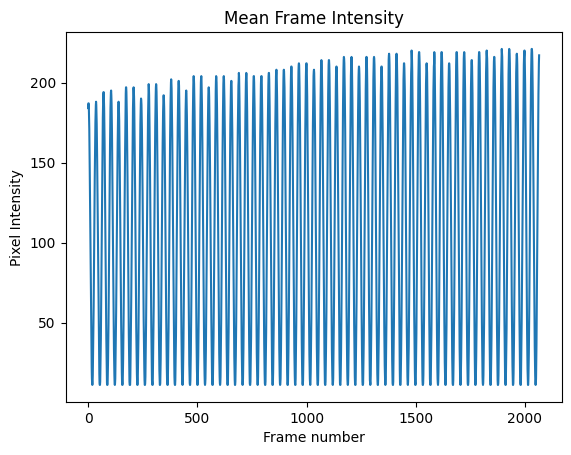

In [7]:
plt.plot(videos[0][1])
plt.title('Mean Frame Intensity')
plt.ylabel('Pixel Intensity')
plt.xlabel('Frame number')

In [8]:
data_table = []
r2_table = []
for video_num, (filename, signal) in enumerate(videos):
    signal_mean = np.mean(signal)
    signal = (signal - signal_mean) / signal_mean

    signal_as_double: matlab.double = matlab.double(signal.astype(np.float64))
    frequency_as_double: matlab.double = matlab.double(frequency)

    data_row = []
    r2_row = [filename]
    for fps in (206.25, 205.5, 204.75):
        observed_r2, observed_amplitude, observed_phase, observed_fit, observed_model_T, observed_signal_T = eng.fourierRegression(signal_as_double, frequency_as_double, matlab.double(fps), nargout=6)
        
        observed_fit = np.array(observed_fit).flatten()
        observed_model_T = np.array(observed_model_T).flatten()
        observed_signal_T = np.array(observed_signal_T).flatten()


        data_row.append([observed_signal_T, signal - np.mean(signal), observed_model_T, observed_fit])
        r2_row.append(observed_r2)

    data_table.append(data_row)
    r2_table.append(r2_row)


findings_df = pd.DataFrame(data=r2_table, columns=['video_name','206.25FPS', '205.5FPS', '204.75FPS'])

print(findings_df)


                            video_name  206.25FPS  205.5FPS  204.75FPS
0  testFPS_6.0hz_0x2NDF_0settings1.avi   0.978530  0.767549   0.412441
1  testFPS_6.0hz_0x2NDF_0settings2.avi   0.977742  0.767709   0.413044
2  testFPS_6.0hz_0x2NDF_0settings3.avi   0.977470  0.761891   0.404483
3  testFPS_6.0hz_0x5NDF_0settings1.avi   0.959629  0.752744   0.405596
4  testFPS_6.0hz_0x5NDF_0settings2.avi   0.955519  0.749502   0.404631
5  testFPS_6.0hz_0x5NDF_0settings3.avi   0.951745  0.745324   0.400781
6  testFPS_6.0hz_0x7NDF_0settings1.avi   0.667937  0.789279   0.689309
7  testFPS_6.0hz_0x7NDF_0settings2.avi   0.820980  0.644145   0.354610
8  testFPS_6.0hz_0x7NDF_0settings3.avi   0.823359  0.647715   0.358062


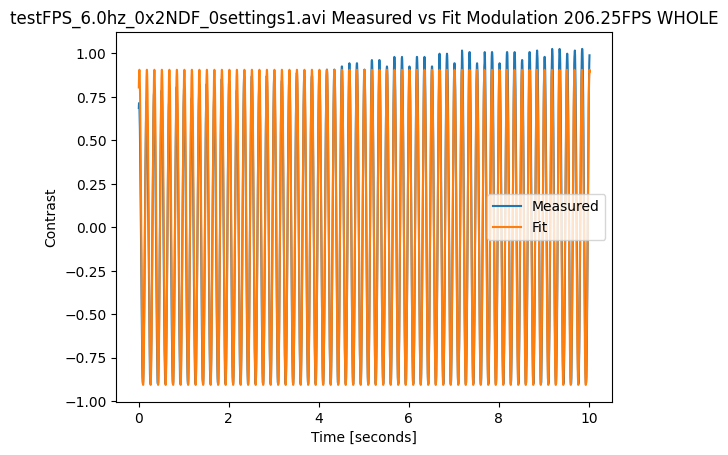

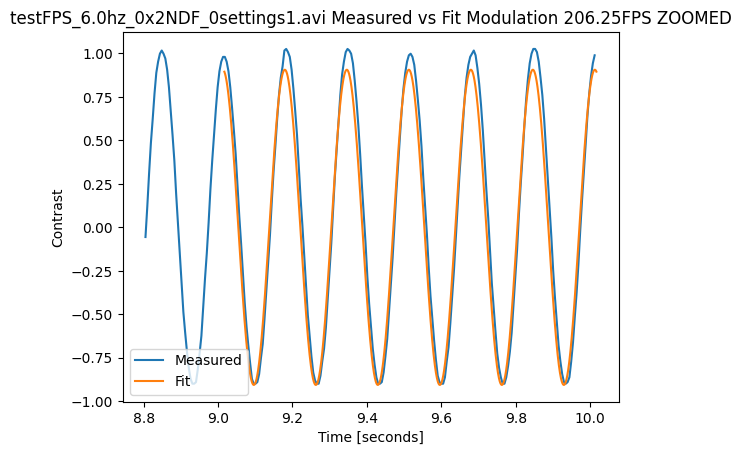

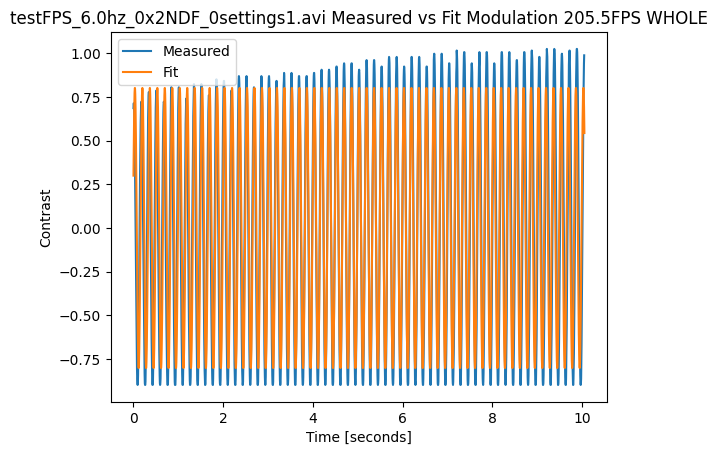

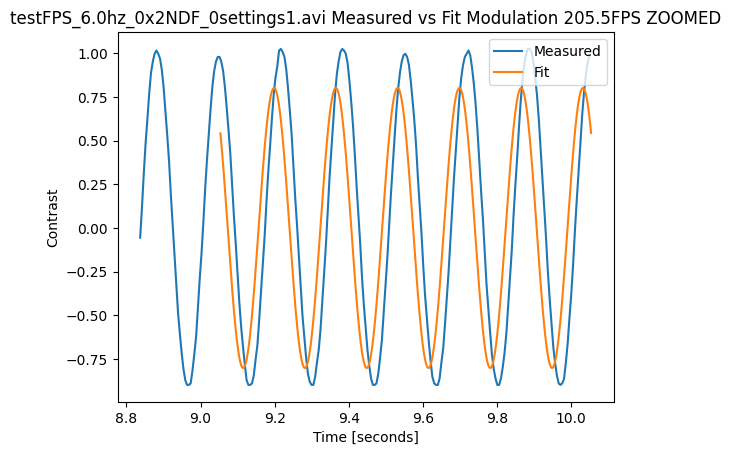

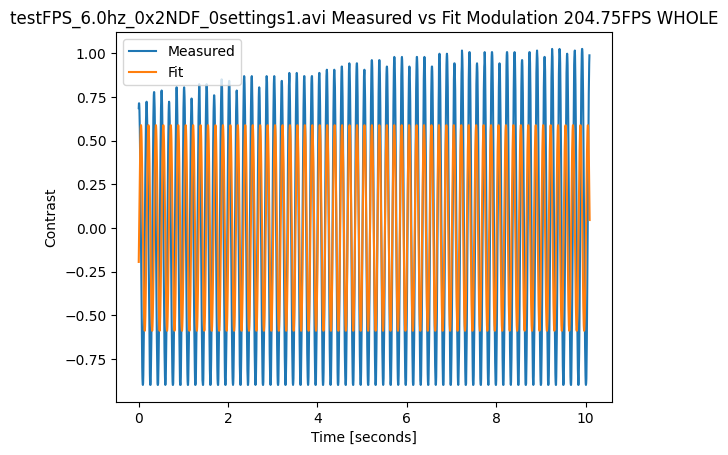

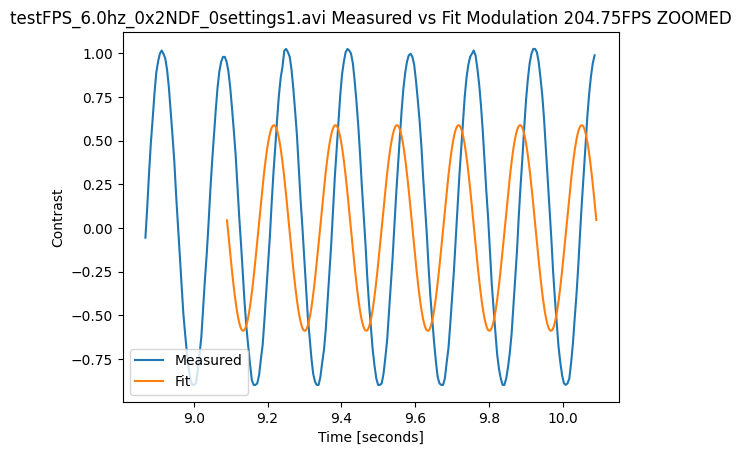

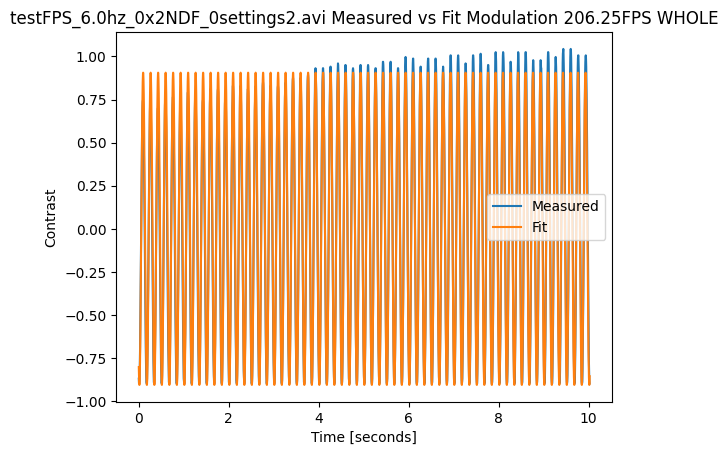

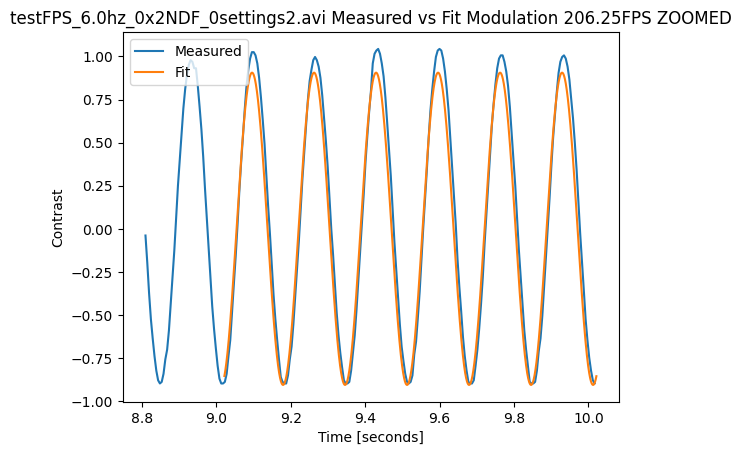

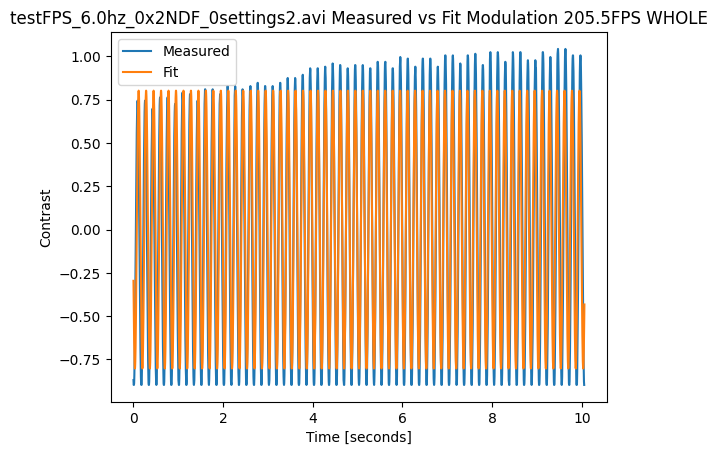

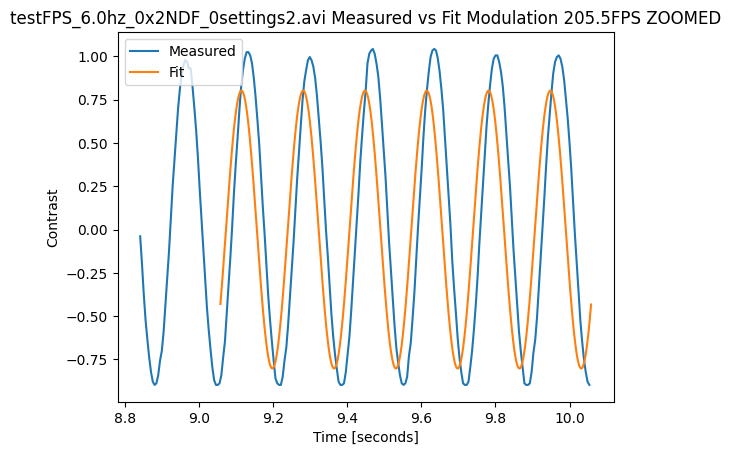

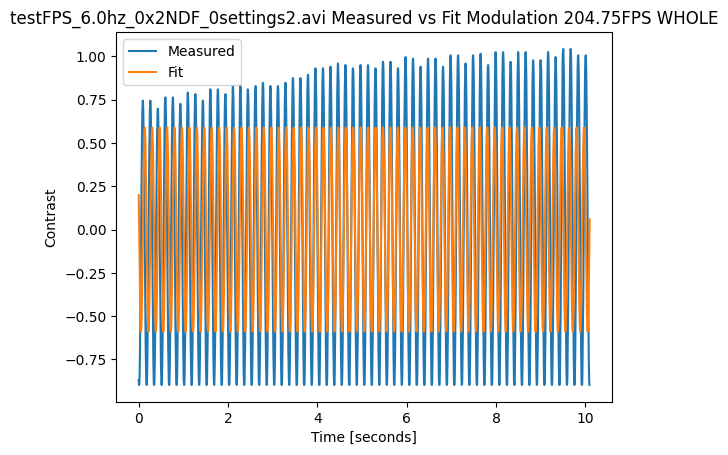

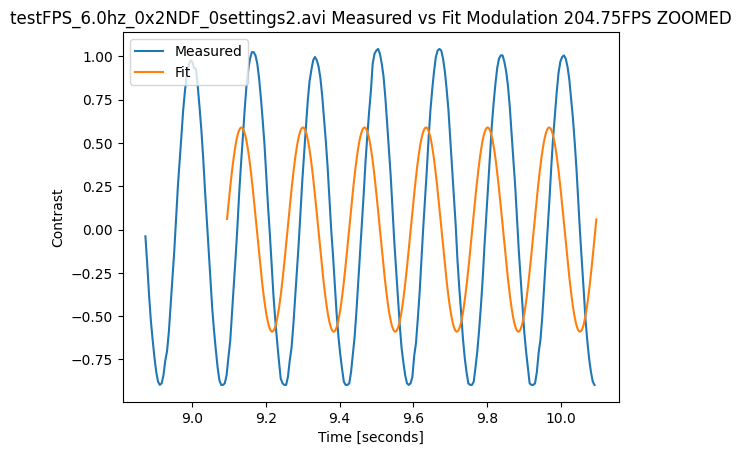

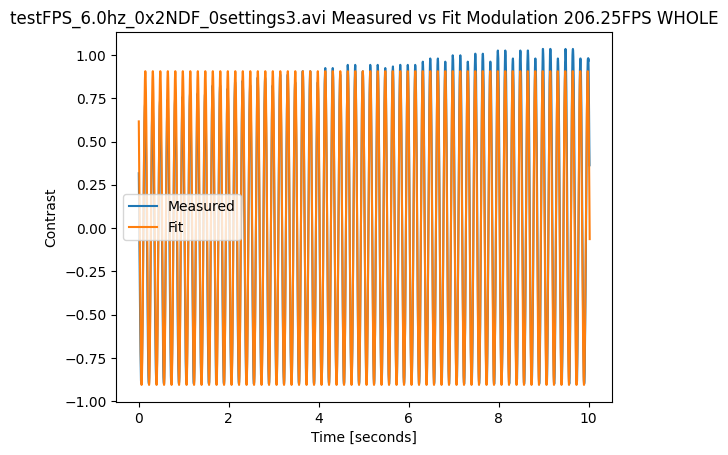

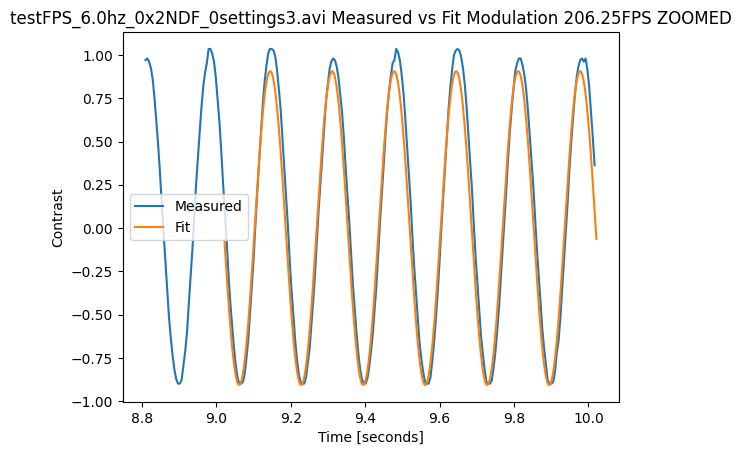

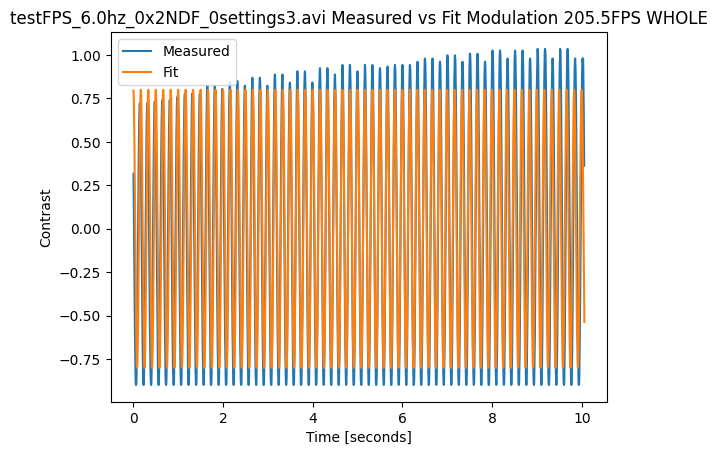

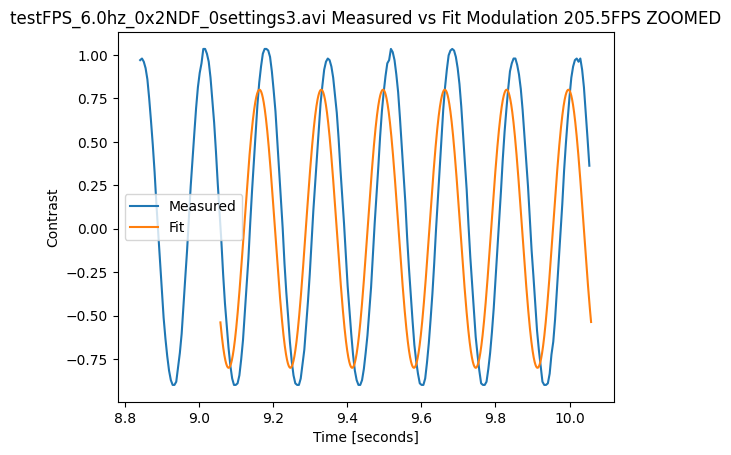

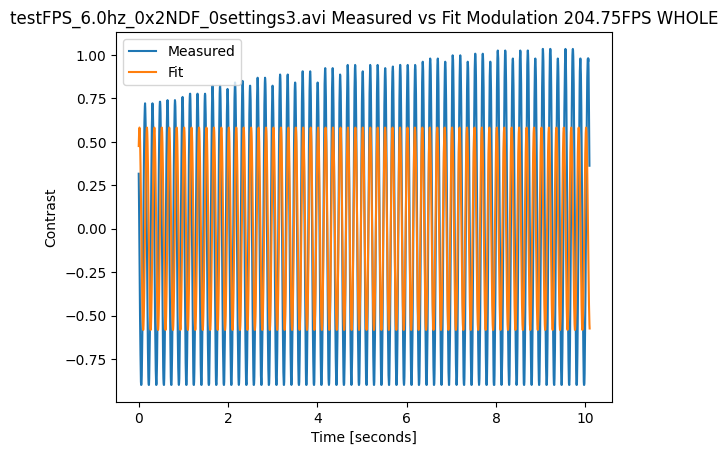

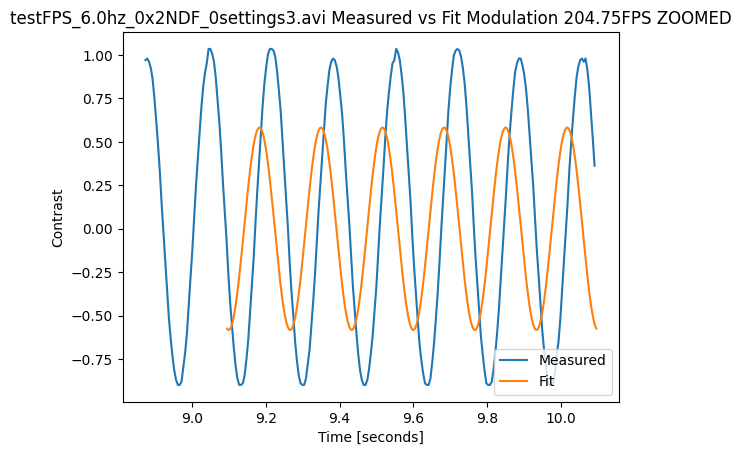

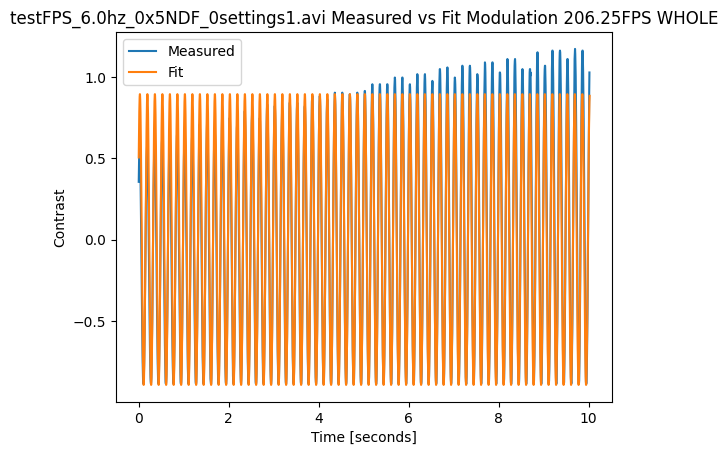

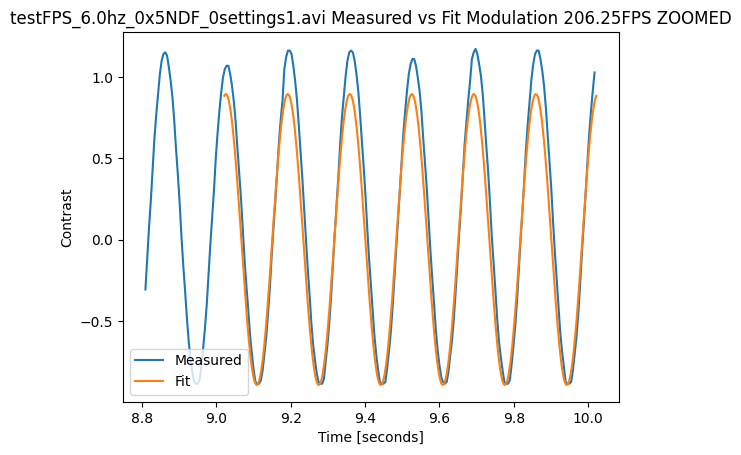

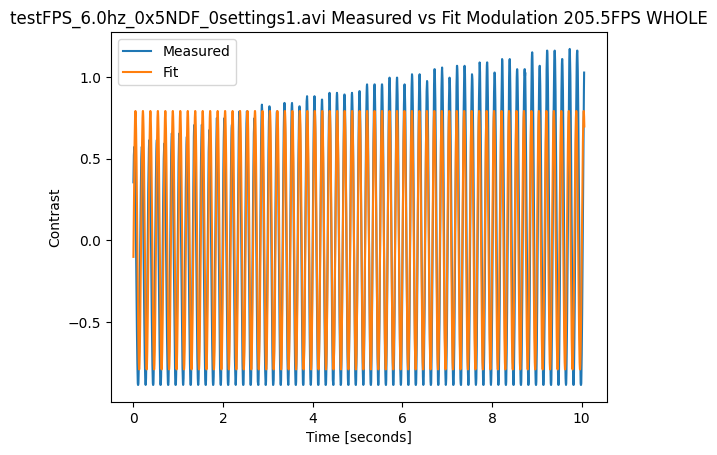

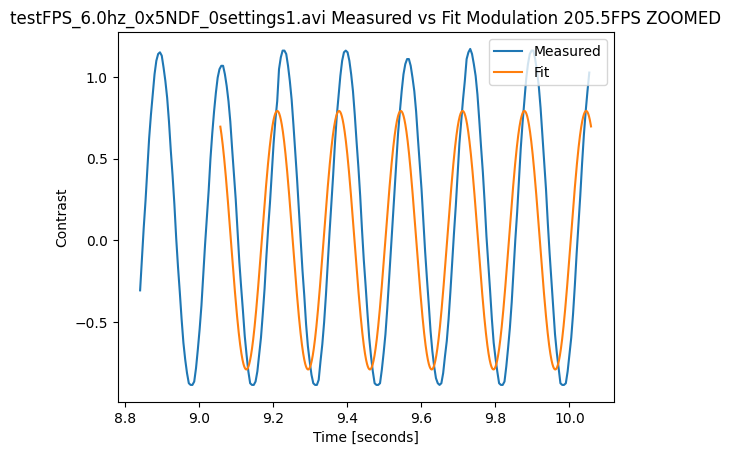

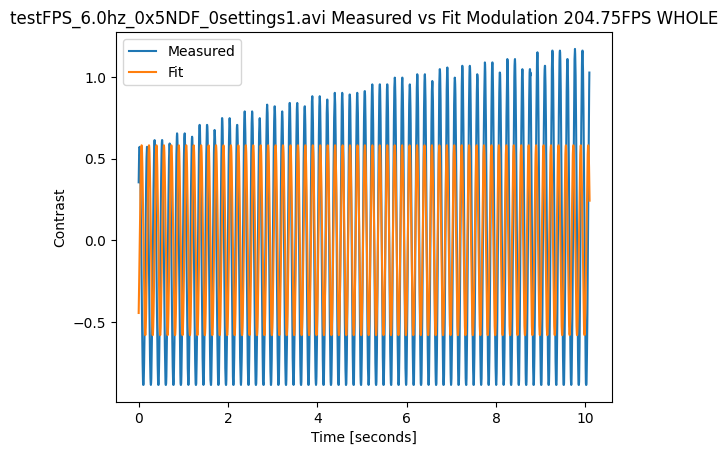

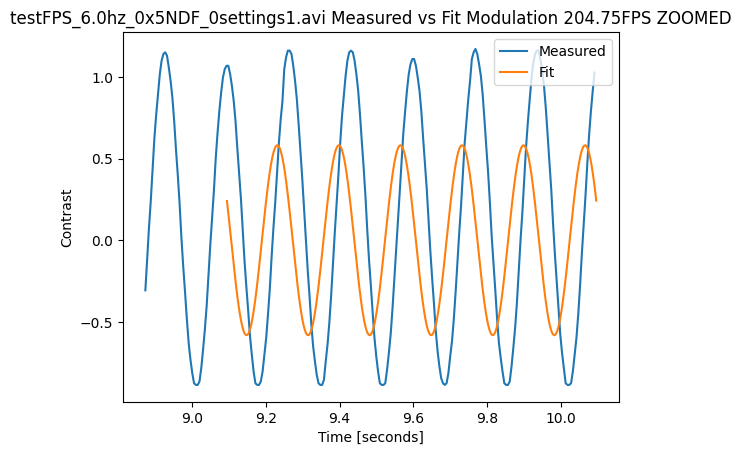

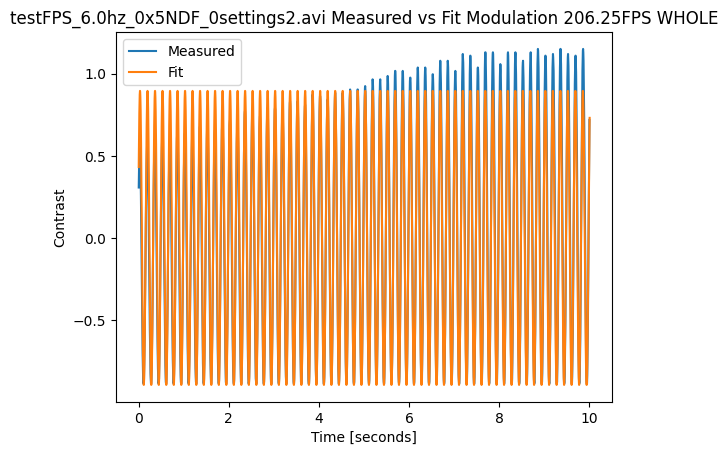

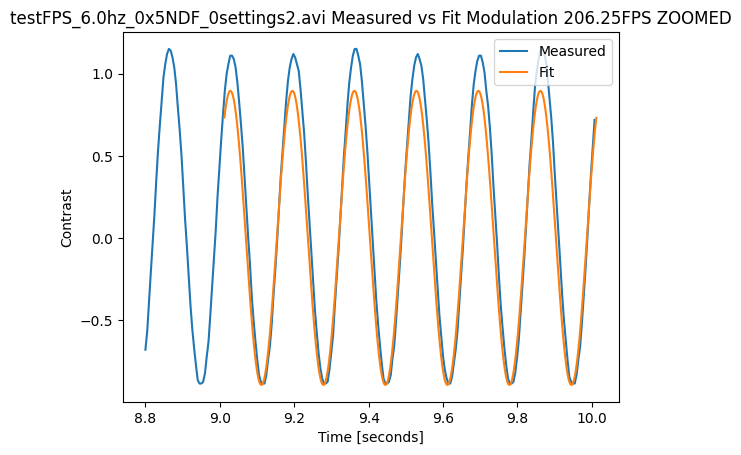

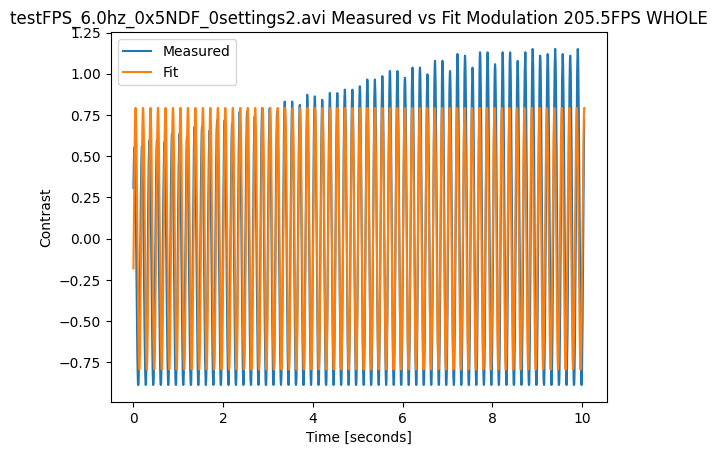

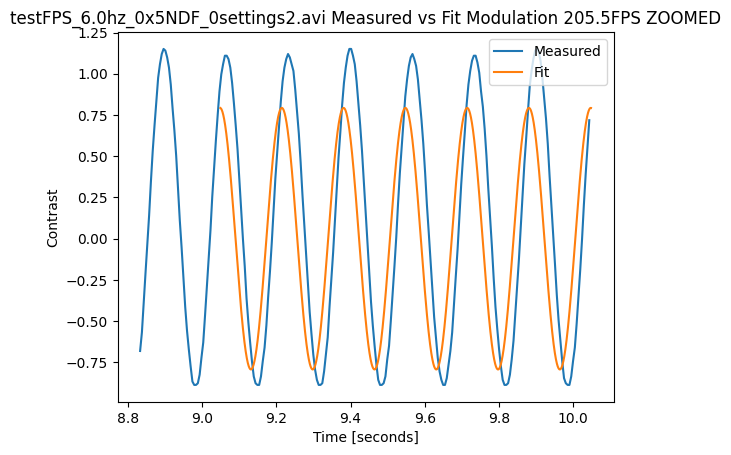

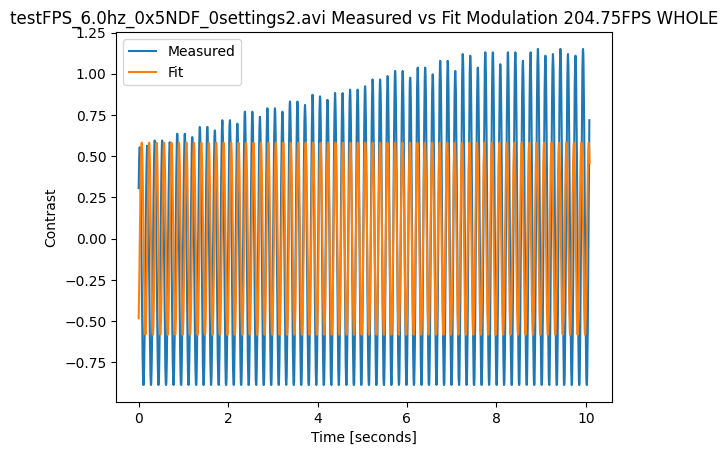

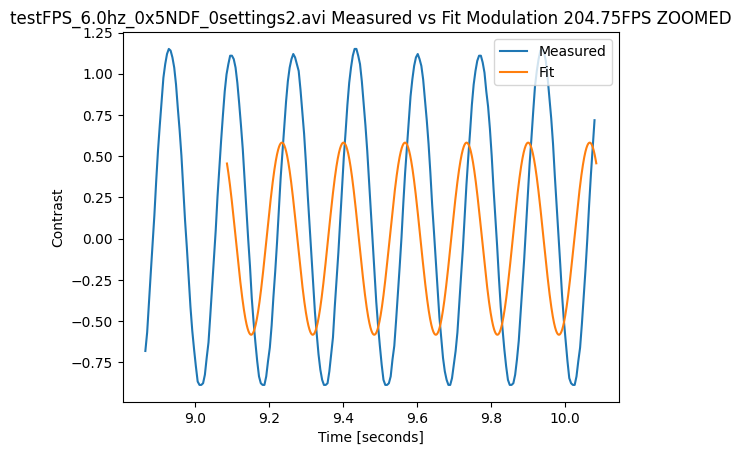

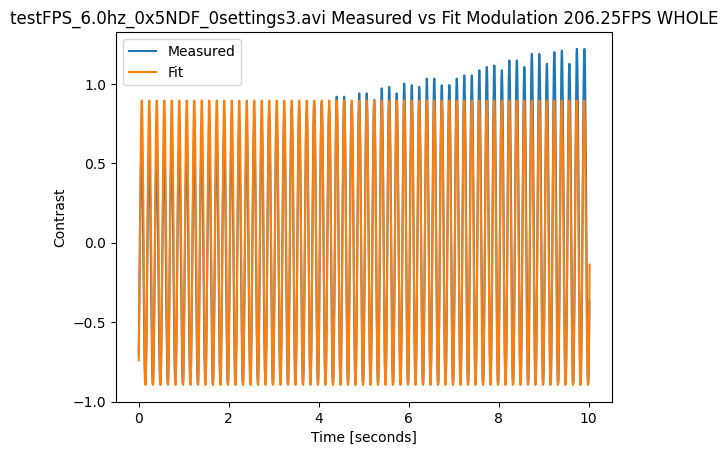

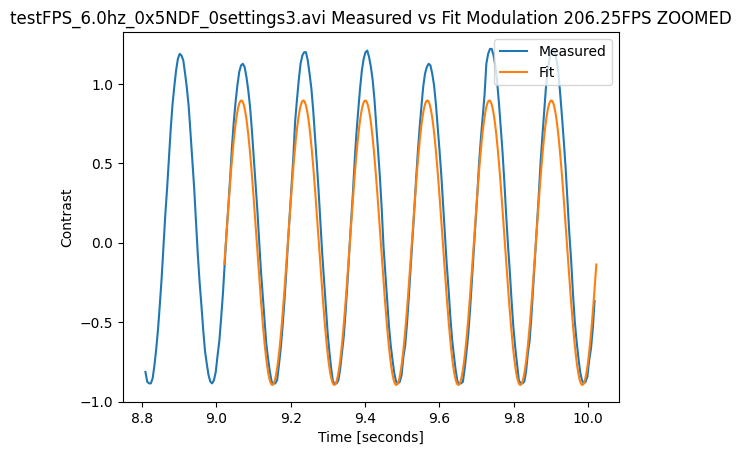

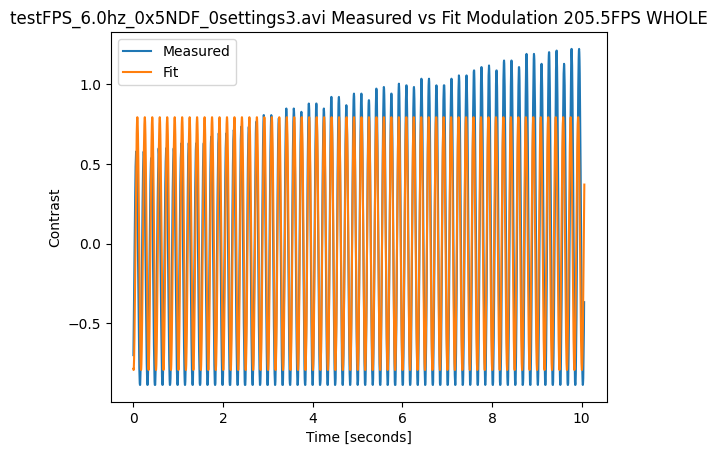

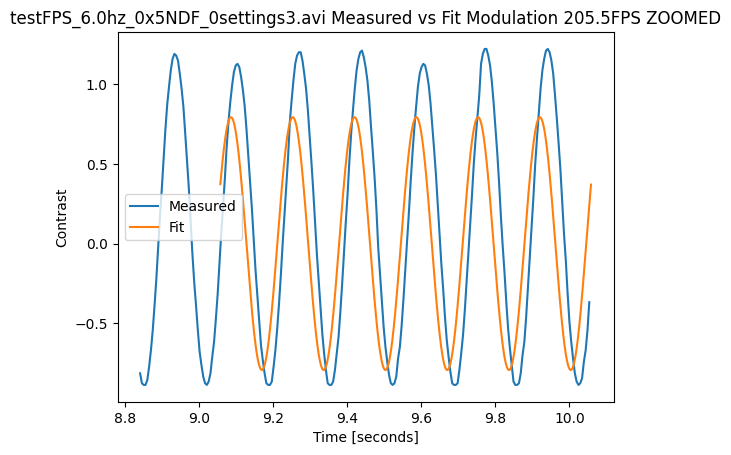

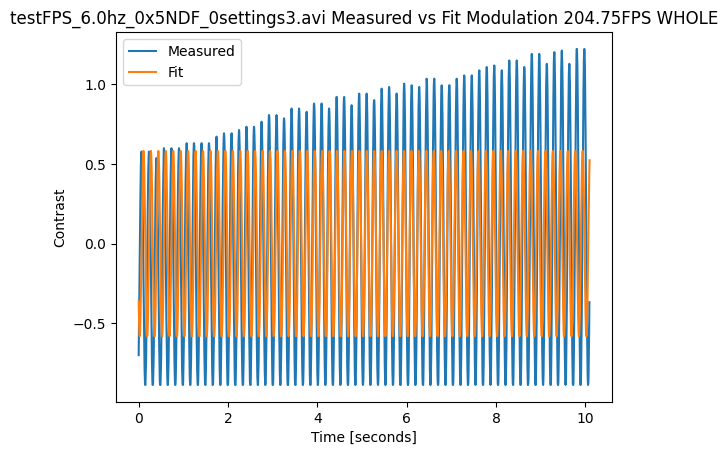

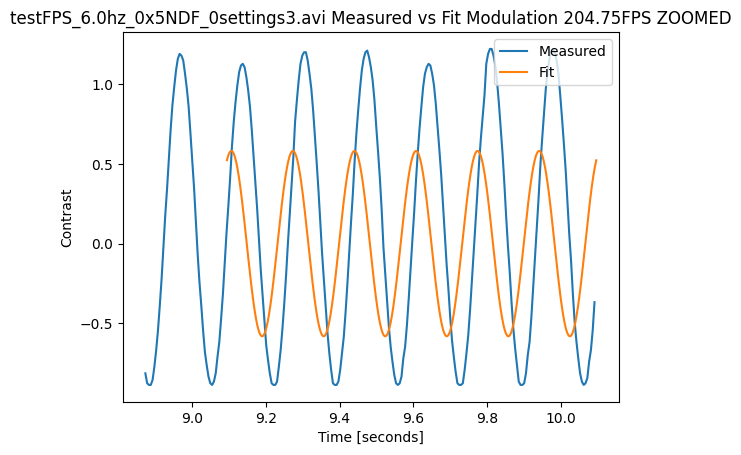

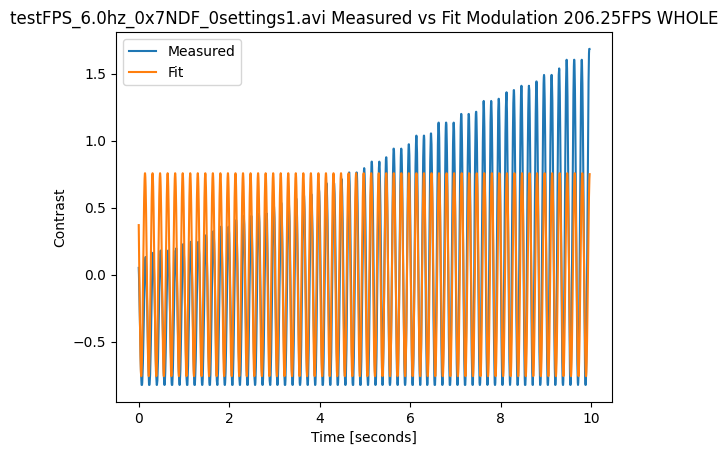

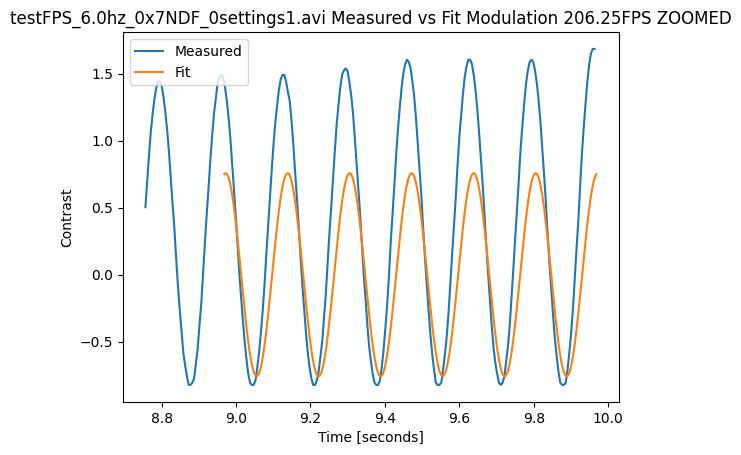

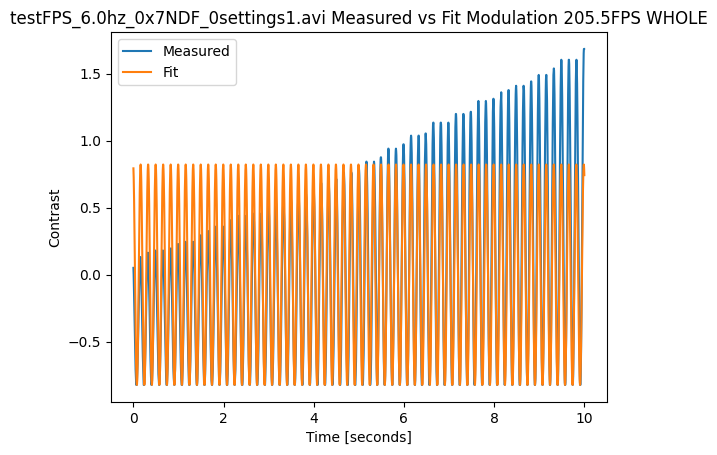

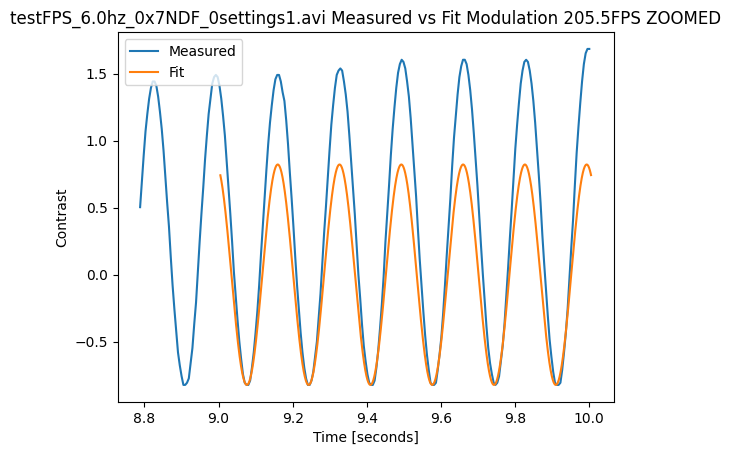

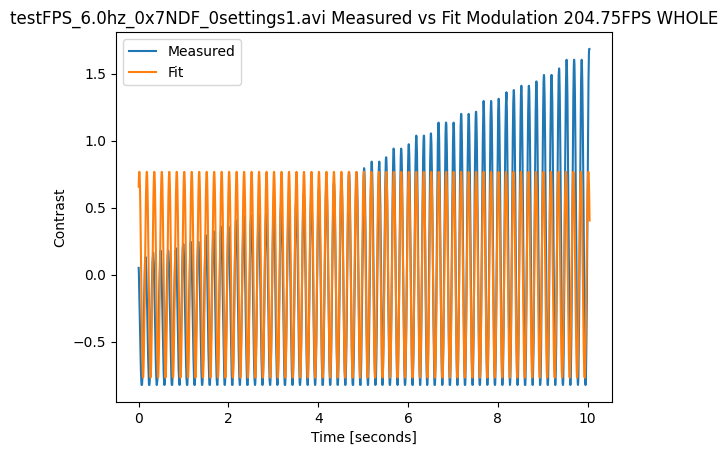

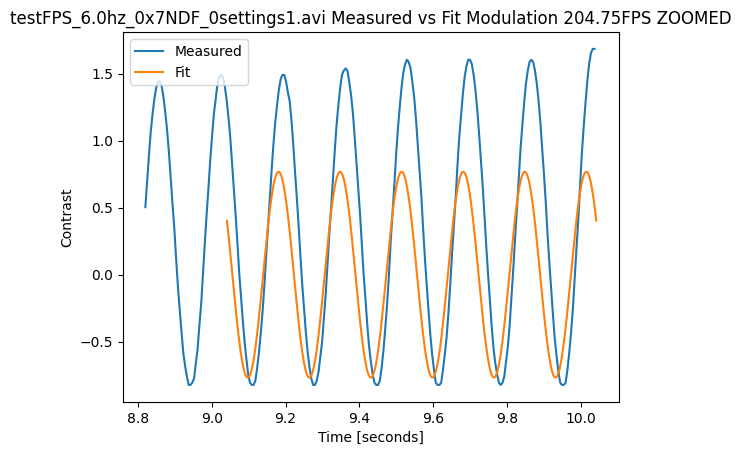

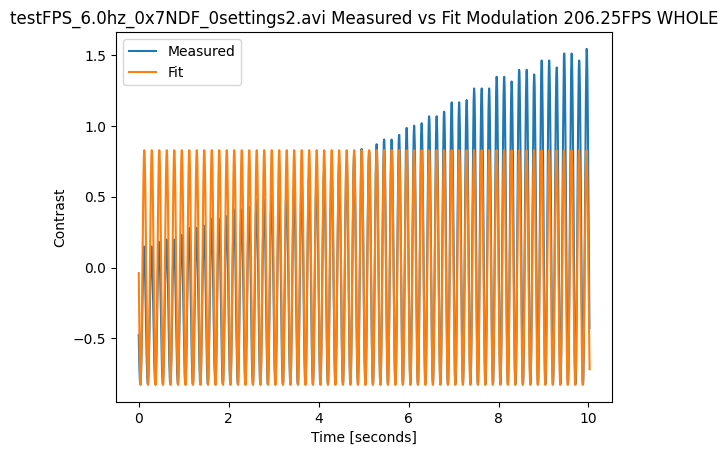

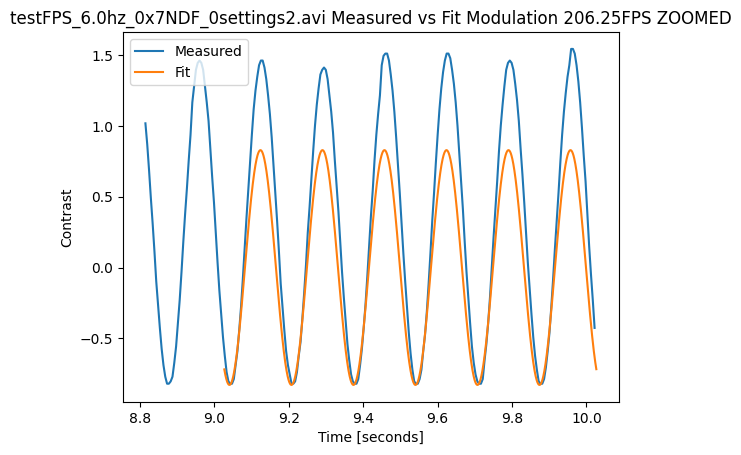

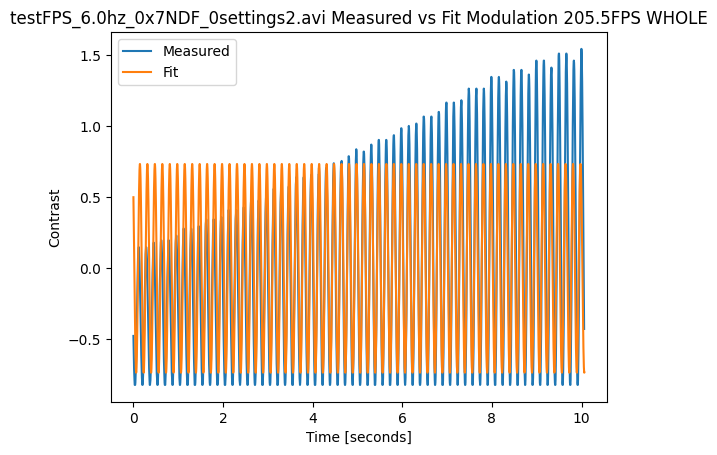

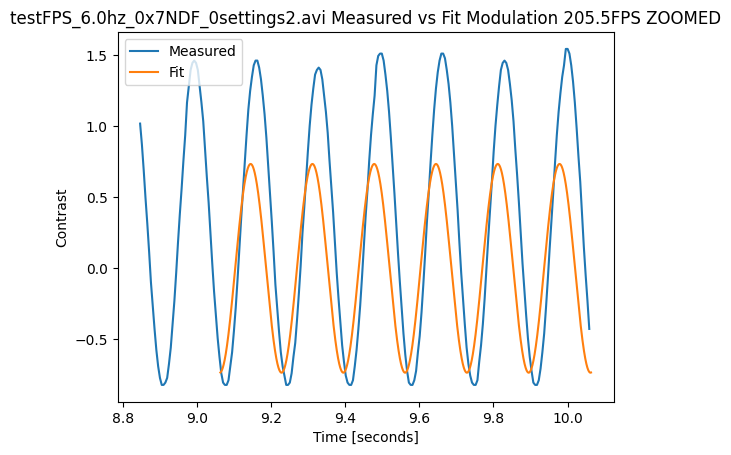

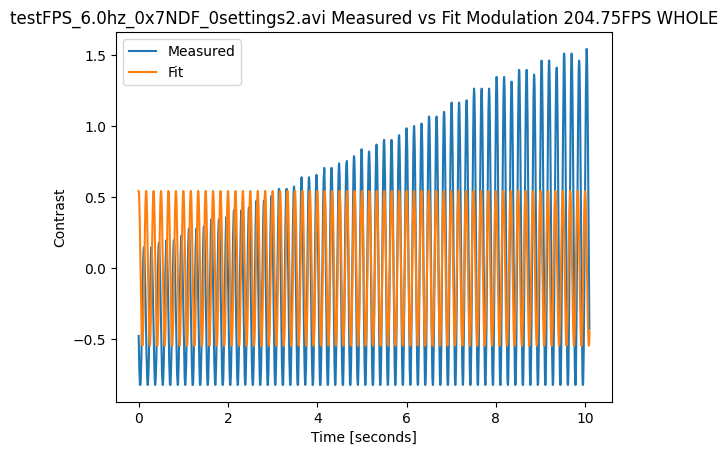

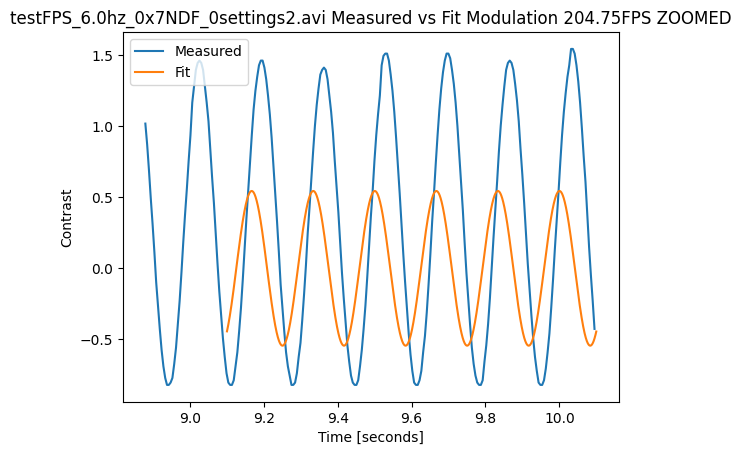

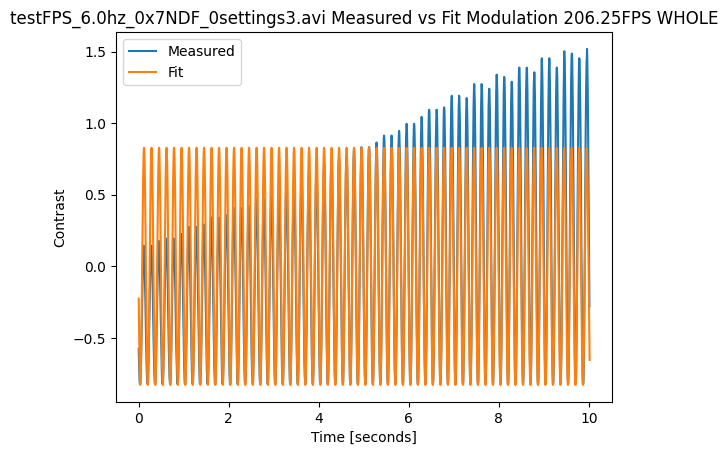

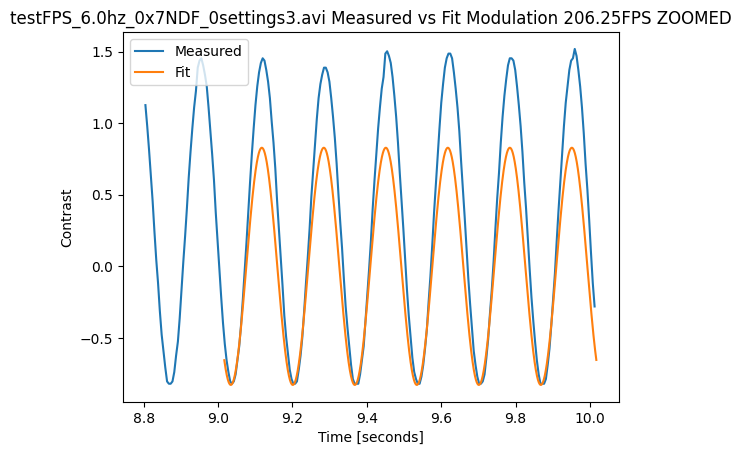

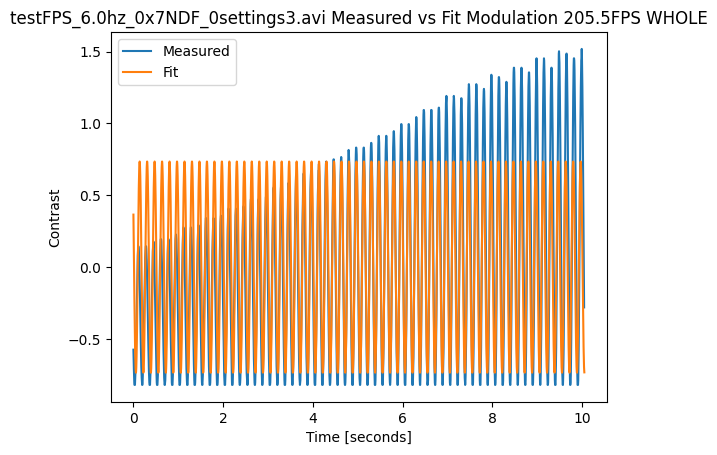

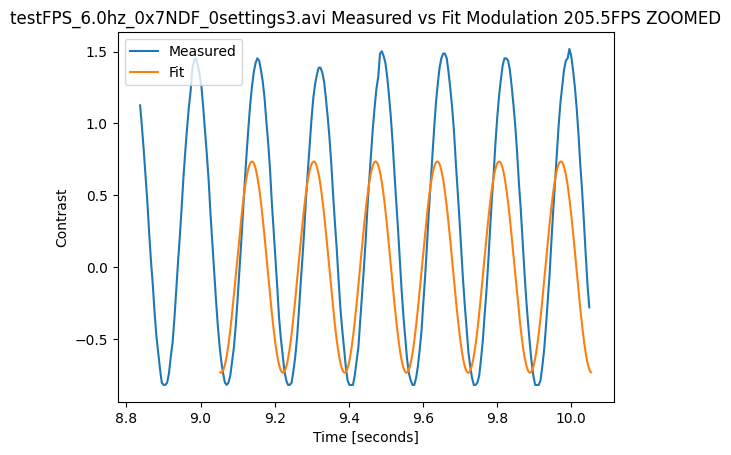

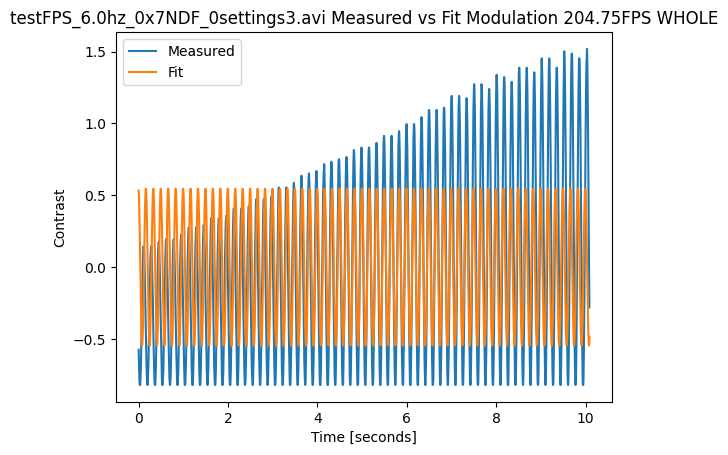

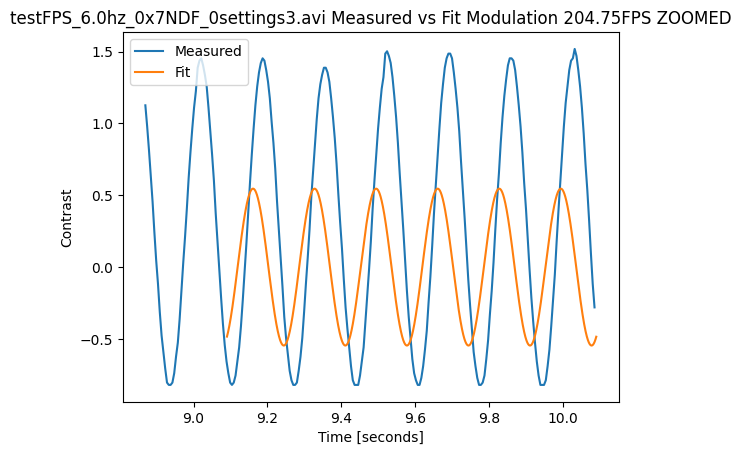

In [9]:
for i, (video_name, video_data) in enumerate(zip(findings_df['video_name'], data_table)):
    for j, fps in enumerate((206.25, 205.5, 204.75)):
        observed_signal_T, signal, observed_model_T, observed_fit = video_data[j]


        plt.plot(observed_signal_T, signal, linestyle='-', label="Measured")
        plt.plot(observed_model_T, observed_fit, linestyle='-', label="Fit")
        plt.legend()
        plt.title(f"{os.path.basename(video_name)} Measured vs Fit Modulation {fps}FPS WHOLE")
        plt.xlabel('Time [seconds]')
        plt.ylabel('Contrast')

        plt.show()


        plt.plot(observed_signal_T[-250:], signal[-250:], linestyle='-', label="Measured")
        plt.plot(observed_model_T[-10000:], observed_fit[-10000:], linestyle='-', label="Fit")
        plt.legend()
        plt.title(f"{os.path.basename(video_name)} Measured vs Fit Modulation {fps}FPS ZOOMED")
        plt.xlabel('Time [seconds]')
        plt.ylabel('Contrast')
        

        plt.show()






In [ ]:
eng.quit()